In [1]:
%matplotlib inline
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import gaussian
from scipy.ndimage import filters

from sklearn.utils import resample

save = False

cm = 1/2.54  # centimeters in inches
sns.set_context('paper', rc={'font.size': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
                          'figure.titleweight': 'bold', 'axes.labelsize':10, 'axes.titlesize':12})


dir_path = os.path.abspath('')

output_path = dir_path + '/Figures/'

In [2]:
def smooth_response(response, filterWidth=8):
    """

    :param response: Trials x Times
    :param filterWidth: SD of Gaussian
    :return: Smoothed response
    """
    if len(response.shape) == 1:
        response = response[np.newaxis, :]
    gauss = gaussian(10 * filterWidth, filterWidth)
    return filters.convolve1d(response, gauss / gauss.sum(), axis=1)


In [3]:
tracker = joblib.load(dir_path + '/ModelAnalysis/FiringRates_readout.pkl')

colors = sns.color_palette(sns.xkcd_palette([ "orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

In [4]:
offset = 0
onset = 100
features = 256 # 512
time_steps = np.arange(-onset, tracker['neutral']['MUA'].shape[1] - onset) #np.arange(offset, tracker[25]['neutral']['MUA_centre'].shape[1])

conds = ['precision','inputGain','outputGain']

n = tracker['neutral']['MUA'].shape[0]

num_draws = 500  

np.random.seed(3)
idx = np.arange(n)


FR_avgs = pd.DataFrame(np.zeros((len(conds) * 3 * n,4)), columns=['Mechanism', 'Attention', 'Image','FR'])
FR_avgs['Attention'] = np.repeat(np.arange(3)[np.newaxis,:],n *len(conds), axis=0).flatten()
FR_avgs['Mechanism'] = np.repeat(np.arange(len(conds))[np.newaxis,:],n *3, axis=1).flatten()
FR_avgs['Image'] = np.repeat(np.repeat(np.arange(n)[:,np.newaxis],3).flatten()[np.newaxis,:], len(conds), axis=0).flatten()


replace_map = {'Attention': {0: 'valid', 1:'neutral', 2:'invalid'},
               'Mechanism': {0: conds[0], 1: conds[1], 2: conds[2]}}
FR_avgs.replace(replace_map, inplace=True)

resp = tracker['neutral']['MUA'][:n, offset:]
resp_gauss = smooth_response(resp)
mean_draws_neutral = list()
for d in range(num_draws):
    # Resampling, with replacement, taking the class imbalance into account
    draw = resample(idx, n_samples=n, random_state=d)
    mean_draws_neutral.append(np.mean(resp_gauss[draw], axis=0))



precision


inputGain


outputGain


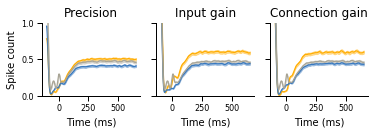

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(13.5*cm, 5*cm), sharey=True, sharex=True)
ax = ax.flatten()

for c, cond in enumerate(conds):
    for a, att in enumerate(['valid', 'invalid', 'neutral']):
        if att == 'neutral':
            
            resp = tracker[att]['MUA'][:n, offset:]
            resp_gauss = smooth_response(resp)
            mean_draws = mean_draws_neutral
        
        else:
           
            resp = tracker[cond][att]['MUA'][:n, offset:]
            resp_gauss = smooth_response(resp)

            mean_draws = list()
            for d in range(num_draws):
                # Resampling, with replacement, taking the class imbalance into account
                draw = resample(idx, n_samples=n, random_state=d)
               
                mean_draws.append(np.mean(resp_gauss[draw], axis=0))
                
        ax[c].plot(time_steps,np.mean(resp_gauss, axis=0), color=colors[a])
        
        ax[c].fill_between(time_steps, np.percentile(np.array(mean_draws), 2.5, axis=0),np.percentile(mean_draws, 97.5, axis=0),
                           color=colors[a], alpha=0.4)

        ax[c].set_ylim([0,1])

    ax[0].set_ylabel('Spike count')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_title('Precision')
    ax[0].set_yticks([0, 0.5, 1])

    ax[1].set_title('Input gain')
    ax[1].set_xlabel('Time (ms)')

    ax[2].set_title('Connection gain')
    ax[2].set_xlabel('Time (ms)')
    
    sns.despine()

    print(cond)

    FR_avgs.loc[(FR_avgs['Mechanism'] == cond) & (FR_avgs['Attention'] == 'valid'), 'FR' ] =((np.sum(
        tracker[cond]['valid']['MUA'][:n,250:], axis=1))/features) * (1000 / 450)
    FR_avgs.loc[(FR_avgs['Mechanism'] == cond) & (FR_avgs['Attention'] == 'invalid'), 'FR'] = ((np.sum(
        tracker[cond]['invalid']['MUA'][:n, 250:], axis=1)) / features) * (1000 / 450)
    FR_avgs.loc[(FR_avgs['Mechanism'] == cond) & (FR_avgs['Attention'] == 'neutral'), 'FR'] = ((np.sum(
        tracker['neutral']['MUA'][:n, 250:], axis=1)) / features) * (1000 / 450)
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig( output_path + 'FiringRates_allConditions.pdf', dpi=300, transparent=True)
else:
    plt.show()



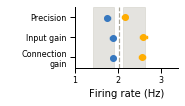

In [6]:
dodge = True
capsize = 0.1
aspect = 1.7 
errwidth = 1.3  

g = sns.catplot(y="Mechanism", x="FR", hue="Attention", data=FR_avgs[FR_avgs['Attention'] != 'neutral'],
                height=4 * cm, aspect=aspect, kind="point",
                palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                legend=False, zorder=6, join=False, dodge=dodge,
                capsize=capsize, errwidth=errwidth, orient='h')

g.set_yticklabels(['Precision', 'Input gain', 'Connection\ngain'])

means = FR_avgs.groupby(['Attention']).mean()
means = means.reset_index()
mean = means.loc[means['Attention'] == 'neutral', 'FR'].values

limits = np.array([1, 3.4])
plt.xlim(limits)

g.ax.set_xticks([1, 2, 3])
g.ax.set_xlabel('Firing rate (Hz)')
g.ax.set_ylabel(' ')
g.ax.axvline(mean, c=colors[2], ls='--', zorder=0)

plt.tight_layout()

plt.axvspan(mean * 1.05, mean * 1.3, color=colors[2], alpha=0.3, zorder=0)
plt.axvspan(mean * 0.7, mean * 0.95, color=colors[2], alpha=0.3, zorder=0)
sns.despine(top=True, right=True)
if save == True:
    g.savefig(figure_path + 'FiringRates_' + mode + '.pdf', dpi=300, transparent=True)
else:
    plt.show()


In [7]:
import random

comps = ['valid vs invalid', 'valid vs neutral', 'invalid vs neutral']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])

# Define p (number of permutations):
p = 10000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)
for cond in conds:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validPreds = FR_avgs.loc[(FR_avgs['Mechanism']==cond) & (FR_avgs['Attention']=='valid'), 'FR'].values
    invalidPreds = FR_avgs.loc[(FR_avgs['Mechanism']==cond) & (FR_avgs['Attention']=='invalid'), 'FR'].values
    neutralPreds = FR_avgs.loc[(FR_avgs['Mechanism'] == cond) & (FR_avgs['Attention'] == 'neutral'), 'FR'].values

    idx = np.arange(len(validPreds) * 2)
    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(np.mean(validPreds) - np.mean(invalidPreds))
                samplePreds = np.concatenate([validPreds, invalidPreds], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(np.mean(validPreds) - np.mean(neutralPreds))

                samplePreds = np.concatenate([validPreds, neutralPreds], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(np.mean(invalidPreds) - np.mean(neutralPreds))

                samplePreds = np.concatenate([invalidPreds, neutralPreds], axis=0)
            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)
                pD.append(np.abs(np.mean(samplePreds[idx[:int(len(idx)//2)]]) - np.mean(samplePreds[idx[int(len(idx) // 2):]])))

            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']= p_val

            results_df = results_df.append({'Mechanism':cond, 'Comparison':comp, 'Difference':diff, 'p-values':p_val, 'significant':p_val<results['alpha-level']},ignore_index=True )


joblib.dump(results,
            dir_path + '/ModelEvaluation/FRPermutationTestsComparisons.pkl',
            compress=True)
results_df.to_csv(dir_path +'/ModelEvaluation/FRPermutationTestsComparisons_df.csv')



precision
valid vs invalid


precision: 0.0
valid vs neutral


precision: 0.0006
invalid vs neutral


precision: 0.0
inputGain
valid vs invalid


KeyboardInterrupt: 